In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 120

np.random.seed(0)

from elman import ElmanNetwork, normalize

In [10]:
data = np.genfromtxt('data/mouse_circle_data.csv', delimiter=',')

xArr = data[:,0]
yArr = data[:,1]

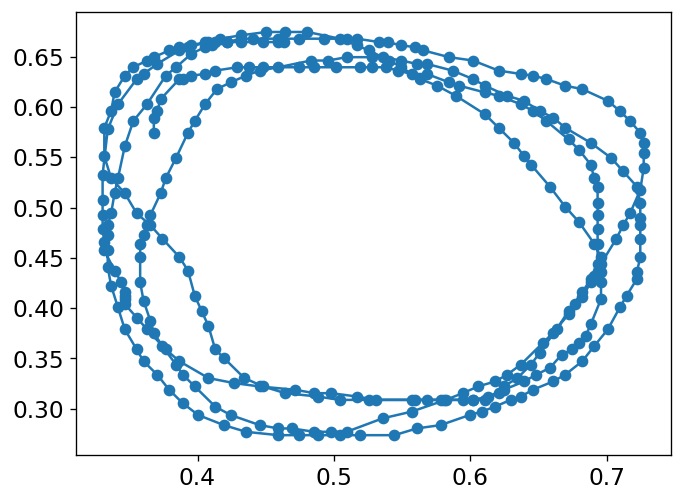

In [12]:
plt.plot(xArr, yArr, '-o')
plt.show()

In [37]:
dsFactor = 4

normXArr = normalize(xArr)[::dsFactor]
normYArr = normalize(yArr)[::dsFactor]

numEpochs = 8000

model = ElmanNetwork(inputDim=2,
                     contextDim=20,
                     outputDim=2,
                     learningRate=.1)

inputArr = np.array(list(zip(normXArr, normYArr)))[:-1]
targetArr = np.array(list(zip(normXArr, normYArr)))[1:]
errorArr = np.zeros(numEpochs) # list to store errors

for epoch in range(numEpochs):
    # Context and output
    contextArr, outputArr = model.forwardSequence(inputArr)
    errorArr[epoch]  = model.backwardSequence(inputArr, contextArr, outputArr, targetArr)
    model.updateParameters()
    
model.save('models/circle.npz')

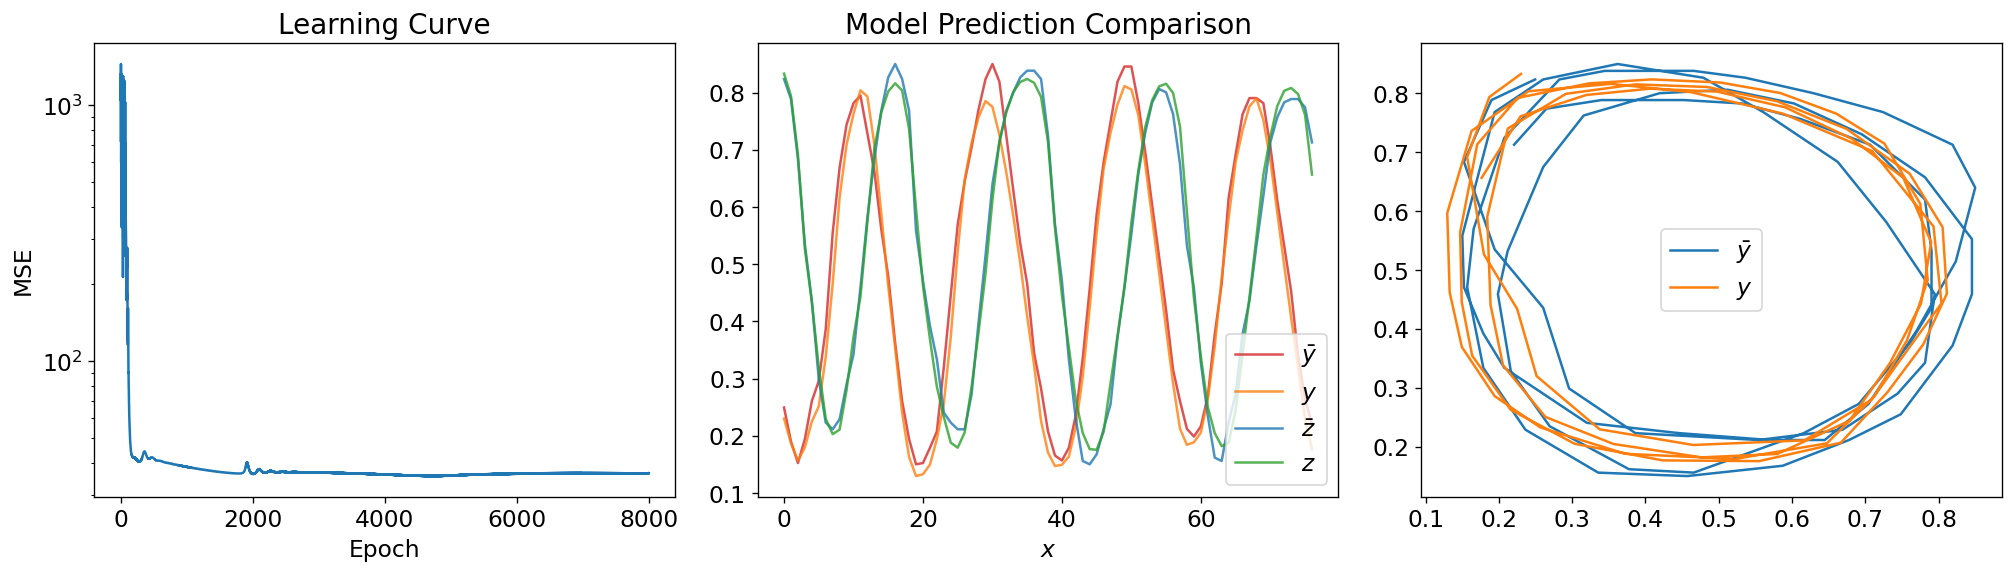

In [38]:
fig = plt.figure(figsize=(17,5))

ax = [None, None, None]
ax[0] = fig.add_subplot(1, 3, 1)

ax[0].plot(errorArr)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_yscale('log')
ax[0].set_title('Learning Curve')

ax[1] = fig.add_subplot(1, 3, 2)

ax[1].plot(targetArr[1:,0], alpha=.8, c='tab:red', label=r'$ \bar y $')
ax[1].plot(outputArr[1:,0], alpha=.8, c='tab:orange', label='$ y $')
ax[1].plot(targetArr[1:,1], alpha=.8, c='tab:blue', label=r'$ \bar z $')
ax[1].plot(outputArr[1:,1], alpha=.8, c='tab:green', label='$ z $')
ax[1].legend()
ax[1].set_xlabel('$x$')
ax[1].set_title('Model Prediction Comparison')

ax[2] = fig.add_subplot(1, 3, 3)

ax[2].plot(targetArr[1:,0], targetArr[1:,1], label=r'$\bar y$')
ax[2].plot(outputArr[1:,0], outputArr[1:,1], label=r'$y$')
ax[2].legend()

fig.tight_layout()

plt.show()

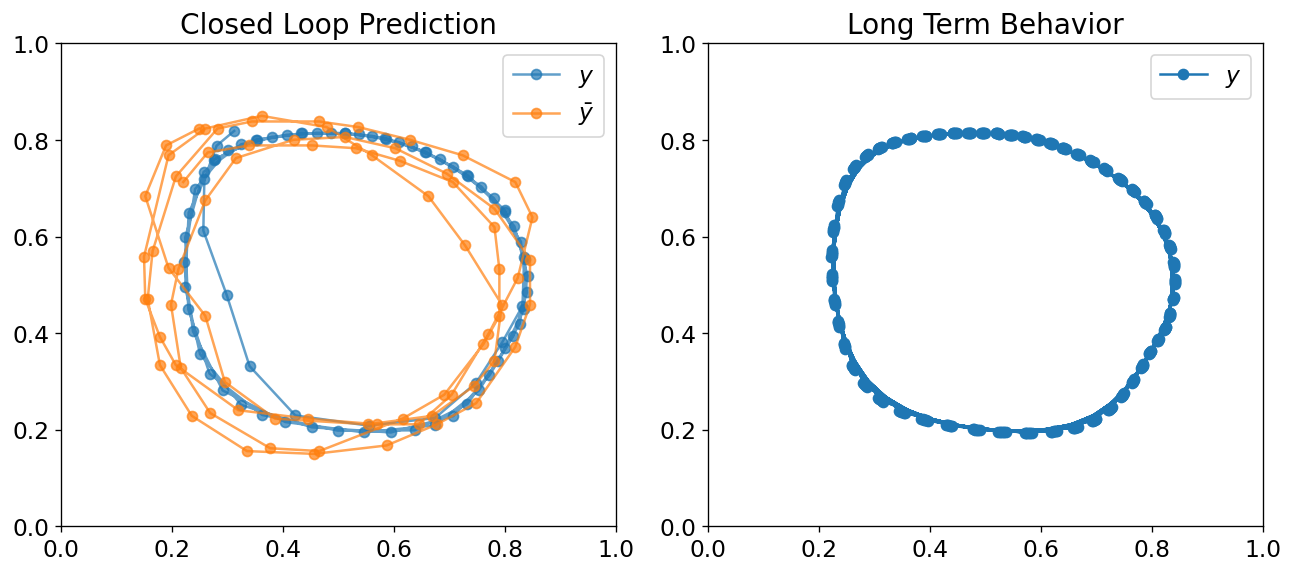

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(11,5))

nSteps = 10000

predictArr = model.predict([normXArr[0], normYArr[0]], predictionSteps=nSteps)

ax[0].plot(predictArr[1:targetArr.shape[0],0], predictArr[1:targetArr.shape[0],1], '-o', alpha=.7, label='$ y $')
ax[0].plot(targetArr[1:,0], targetArr[1:,1], '-o', alpha=.7, label=r'$\bar y$')
ax[0].legend()
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_title('Closed Loop Prediction')

ax[1].plot(predictArr[-nSteps//30:,0], predictArr[-nSteps//30:,1], '-o', label='$ y $')
ax[1].legend()
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_title('Long Term Behavior')

fig.tight_layout()
plt.show()